<h1> Clasificador de imágenes de tomografías de coherencias óptica de la retina del ojo </h1>

<h1> Modo (Test ) </h1>

In [1]:
Modo_Entrenamiento = False

<h2> Entrenamiento de la red VGG16 Multiclase </h2>
<h3> Librerias </h3>

In [2]:
import os
import sys
import math
import random
import cv2 as cv2         # Necesitas installar pip install  opencv-python
import itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.metrics import  roc_auc_score, f1_score, roc_auc_score,roc_curve,auc
from PIL import Image
from scipy import interp
from itertools import cycle
%matplotlib  inline

print(tf.__version__)
print(sys.version)

2.0.0
3.7.5 (default, Oct 31 2019, 15:18:51) [MSC v.1916 64 bit (AMD64)]


<h1> Definicion de variables </h1>

<h2> Directorios </h2>

In [3]:
# Definicion de las rutas donde se guardara los modelos ya entrenados y un archivo log donde almacenamos
# la informacion del 'accuracy' y el 'loss'
M_Y_L = '../Modelos_y_Logs/'

# Definicion de los nombres de los modelos.
nameModel = "VGG16_Multi"

dir_modeloVGG16       =  M_Y_L +'VGGnet16.h5'
dir_logVGG16          =  M_Y_L +'logsVGG16.npy'

save_matriz = "..\MatrixC\ " +  nameModel + '.jpg'
save_curve  = '../Graficos/loss_curve_'+ nameModel + '.png'

# Ruta raiz donde guardar los CSV.
dir_CSV = '../DirDataSet/'

# Definicion de clases.
Clases = ['CNV','DME','DRUSEN','NORMAL']


NCSV    = [ dir_CSV + "ENT.csv",  dir_CSV + "VAL.csv",  dir_CSV + "TEST.csv"] 

<h1> Hyperparametros </h1>

In [4]:
# Asigancion del tamaño de entrada de las imagenes a la red.
Size_Fotos = 224
size = (Size_Fotos, Size_Fotos, 3)

# Buffers.
Buffer_train = 16
Buffer_validacion = 16
Buffer_test = 16

ENTRENAMIENTO = None
VALIDACION = None
TEST = None

<h2> Volcar los datos </h2>
Usando los csv volcaremos las imagenes en 3 dataFrame, esto nos permitira crear un formato util(Sin desbordar la ram) mediate lotes de datos que iremos suministrando a la red.

In [5]:
def creacion_DATA():
    # Creacion de la variable DATA para generar el lote. Esto es muy util si queremos appliar el data set ya que le podemos
    # añadir rotaciones traslaciones a las imagenes para ampliar el numero del data Set
    DATA     = ImageDataGenerator(rescale=1./255)
    
    train_df = pd.read_csv(NCSV[0],dtype=str)
    val_df   = pd.read_csv(NCSV[1],dtype=str)
    test_df  = pd.read_csv(NCSV[2],dtype=str)

    # Genero los lotes de imagenes para cada fase del proyecto, especificando el directorio donde se encuentra las fotos
    # el tamaño de las mismas, el tamaño del lote y el tipo de clase(en este caso es categorica porque va asociada a una etiqueta).

    ENTRENAMIENTO = DATA.flow_from_dataframe(directory=None,
                                             dataframe=train_df, 
                                             target_size= (Size_Fotos,Size_Fotos), 
                                             shuffle=True, 
                                             batch_size=Buffer_train, 
                                             class_mode= 'categorical')
    VALIDACION = DATA.flow_from_dataframe(directory=None, dataframe=val_df, target_size= (Size_Fotos,Size_Fotos), shuffle=True, batch_size=Buffer_validacion, class_mode='categorical')
    TEST = DATA.flow_from_dataframe(directory=None,dataframe=test_df, target_size= (Size_Fotos,Size_Fotos), shuffle=False, batch_size=Buffer_test)

    # El numero de lostes en el que se ha dividido el dataset.
    STEP_SIZE_TRAIN = ENTRENAMIENTO.n//ENTRENAMIENTO.batch_size
    STEP_SIZE_VALID = VALIDACION.n//VALIDACION.batch_size
    STEP_SIZE_TEST  = TEST.n//TEST.batch_size
    
    Muestra_Datos(train_df,val_df,test_df)
    return ENTRENAMIENTO,VALIDACION,TEST,STEP_SIZE_TRAIN,STEP_SIZE_VALID

<h3> plt_Curva_Aprendizaje </h3>
Nos permite mostrar dos graficas con la evolucion por episodios del 'accuracy' y el 'loss'.
Estas graficas se guardan en el directorio <b> Graficos </b>
<h4> Argumentos </h4>
<ul> <li> <b> history </b> : Variable que contiene la informacion del accuracy y loss de una epoca determinada.</li>
    <li> <b> name </b> name : nombre del modelo </li> 
</ul>
<h3> Ejemplo </h3>
<img src = "../Imagen/loss_curve_VGG16_Multi.png" >

In [6]:
# Muesta dos graficas. Una es el 'accuracy' y la otra 'loss', en cada una de ella se enfrenta los datos del entrenamiento con los de validacion
def plt_Curva_Aprendizaje(history, name):
    plt.figure(figsize=(15, 15))
    plt.subplot(1,2,1)
    plt.plot(history.item()['accuracy'])
    plt.plot(history.item()['val_accuracy'])
    plt.title('Modelo de Exactitud')
    plt.ylabel('Exactitud')
    plt.xlabel('Epoca')
    plt.legend(['train','validacion'], loc='upper left')
    #plt.savefig('./curva_perdida'+ name + '.png')
    plt.subplot(1,2,2)
    plt.plot(history.item()['loss'])
    plt.plot(history.item()['val_loss'])
    plt.title('model loss')
    plt.ylabel('perdida')
    plt.xlabel('epoch')
    plt.legend(['train', 'validacion'], loc='upper left')
    plt.savefig(save_curve)
    plt.show()

<h3> Dibujo_Matrix_Confusion </h3>
Funcion que nos permite crear y visualizar 2 matrices de confusion. Estas matrices describe el desempeño del modelo de clasificacion. En otras palabras, la matriz de confusion es una forma de resumir el rendimiento del clasificador.

Las filas  representan el valor real de los datos y las columnas el valor predicho. Las celdas de la matriz corresponde al numero o porcentage de imagenes que son predichas en una determinada fila y son de una columna. 

<img src = "../Imagen/Matriz de Confusion.png" > </img>

<ul>
    <li>
        <b> VP </b> es la cantidad de positivos que fueron clasificados correctamente como positivos por el modelo. </li>
    <li> <b> VN </b> es la cantidad de negativos que fueron clasificados correctamente como negativos. </li>
    <li> <b> FN </b> es la cantidad de positivos que fueron clasificados incorrectamente como negativos. </li>
    <li> <b> FP </b> es la catidad de negativos que fueron clasificaso incorrectamente como positivos. </li>
    </ul>

<h4> Argumentos </h4>
<ul>
    <li> <b> CM </b> Matriz de confusion. </li>
    <li> <b> clases </b> Lista de nos nombres de las clases. </li>
    <li> <b> name </b> El nombre del modelo, que nos servira para guardar la imagen. </li>
    <li> <b> cmap </b> El mapeo de color, en este cado usaremos una paleta azul. </li>
    </ul>

In [7]:
# Matriz de confucion.             
def Dibujo_Matrix_Confucion(CM, clases, name, cmap = plt.cm.Blues):
    #fig = plt.figure(figsize=(15,15))
    fig, axs = plt.subplots(1, 2, constrained_layout=True,figsize=(10,10))
    
    #fig.xlabel('Prediccion',fontdict = {'size':22})
    #fig.ylabel('Observacion',fontdict = {'size':22})
    
    #ax.set_title('Numero Imagenes totales {}'.format(np.sum(CM)))
    cax = axs[0].matshow(CM,  interpolation='nearest', cmap=cmap)
    thresh = 100.
    #fig.colorbar(cax)
    
    for i, j in itertools.product(range(CM.shape[0]), range(CM.shape[1])):
        axs[0].text(j, i, '{}%'.format(round((CM[i, j]/ np.sum(CM[:,j]))*100, 3)), horizontalalignment = 'center', fontsize=13, verticalalignment='center', color = 'white' if round((CM[i, j]/ np.sum(CM[:,j]))*100, 3) > thresh else 'black')
    
    axs[0].set_xlabel('Observacion',fontdict = {'size':22})
    axs[0].set_ylabel('Prediccion',fontdict = {'size':22})

    axs[0].xaxis.set_label_position(position = 'top')
    axs[0].set_xticklabels([''] + clases,fontdict = {'fontsize':13})
    axs[0].set_yticklabels([''] + clases,fontdict = {'fontsize':13})
    fig.suptitle('Nº Total {}'.format(np.sum(CM)), fontsize=22)
    
    
    #ax = fig.add_subplot(122)
    cax = axs[1].matshow(CM,  interpolation='nearest', cmap=cmap)
    thresh = 100.
    #fig.colorbar(cax)
    
    for i, j in itertools.product(range(CM.shape[0]), range(CM.shape[1])):
        axs[1].text(j, i, CM[i, j], horizontalalignment = 'center', verticalalignment='center', fontsize=13, color = 'white' if round((CM[i, j]/ np.sum(CM[:,j]))*100, 3) > thresh else 'black')

    axs[1].set_xticklabels([''] + clases,fontdict = {'fontsize':13})
    axs[1].set_yticklabels([''] + clases,fontdict = {'fontsize':13})

    
    fig.savefig(save_matriz)
    plt.show()
    

<h3> Muestra de Datos </h3>
Funcion nos permite mostrar como estan distribuidos los datos entre las diferentes categorias(Entrenamiento, Validacion, Test) y este a su vez como estan para cada clase.
<ul>
    <li>
        <b> ENTRENAMIENTO </b> Estructura de datos compuesto por  pares de valor (Imagen,label). Que usaremos para limentar la red neuronal para entrenarla. </li>
    <li> <b> VALIDACION </b> Estructura de datos compuesto por pares de valor (Imagen, label). Que  usaremos para validar los datos al finalizar cada epoca. </li>
    <li> <b> TEST </b>Estructura de datos compuesto por pares de valor (Imagen, label). Que usaremos para una verificacion final de los datos y una evaluacion de los mismos. </li> 
    </ul>

<h3> Ejemplo </h3>
<img src = "../Imagen/barras_example.png" ></img>

In [8]:
# Grafica de barras. Muestra el nuemro de imagenes que pertenece a cada clase y ademas cuanto usaremos para el entrenamiento, validacion y test. 
def Muestra_Datos(ENTRENAMIENTO,VALIDACION,TEST):

    #n_filer = np.array([[(dire , Cl, len(glob.glob('./' + dire + '/' + Cl + '/**')))  for Cl in Clases ]  for dire in Directorios])
    n_filer = [ele for ele in zip(ENTRENAMIENTO.groupby('class')['class'].count(),VALIDACION.groupby('class')['class'].count(),TEST.groupby('class')['class'].count())]
    n_filer = np.array(n_filer)
    
    figura, m = plt.subplots(1,1, figsize=(20,20))
    
    index = np.arange(3)
    for n,cl in enumerate(Clases):
        r = plt.bar(index + 0.20 * n     , n_filer[n,:], 0.20, alpha = 0.8, label = cl)
    
    plt.xticks(index + 0.35, ['ENT','VALI','TEST'], size=22)
    plt.yticks(size=22)
    plt.legend(loc=1, prop={'size': 22})
    plt.tight_layout()
    
    plt.xlabel('Tipo', fontdict = {'size':22})
    plt.ylabel('N datos', fontdict = {'size':22})
    plt.title('DATOS', fontdict = {'size':22})
    plt.show()

<h3> Muestra Entrenamiento </h3>
Funcion que toma como argumento el conjunto de datos de entrenamiento y visualiza uno de los lotes de 16 imagenes para el usuario.

In [9]:
# Permite ver un muestreo del conjunto de entrenamiento junto a la clase al que pertenece.    
def muestra_train(ENTRENAMIENTO):
    t_x , t_y = next(ENTRENAMIENTO)
    figura, m = plt.subplots(4, 4,figsize=(20, 20))
    for (sub_x, sub_y, sub_n) in zip(t_x, t_y, m.flatten()):
        sub_n.imshow(sub_x[:,:,0], cmap = 'bone')
        sub_n.set_title(', '.join([Cl for Cl, n_pun in zip(Clases, sub_y) if n_pun > 0.5]), fontdict = {'size':16})
        sub_n.axis('off')
    plt.show()

<h1> Volcado Datos y Muestra </h1>

Found 58496 validated image filenames belonging to 4 classes.
Found 3249 validated image filenames belonging to 4 classes.
Found 3249 validated image filenames belonging to 4 classes.


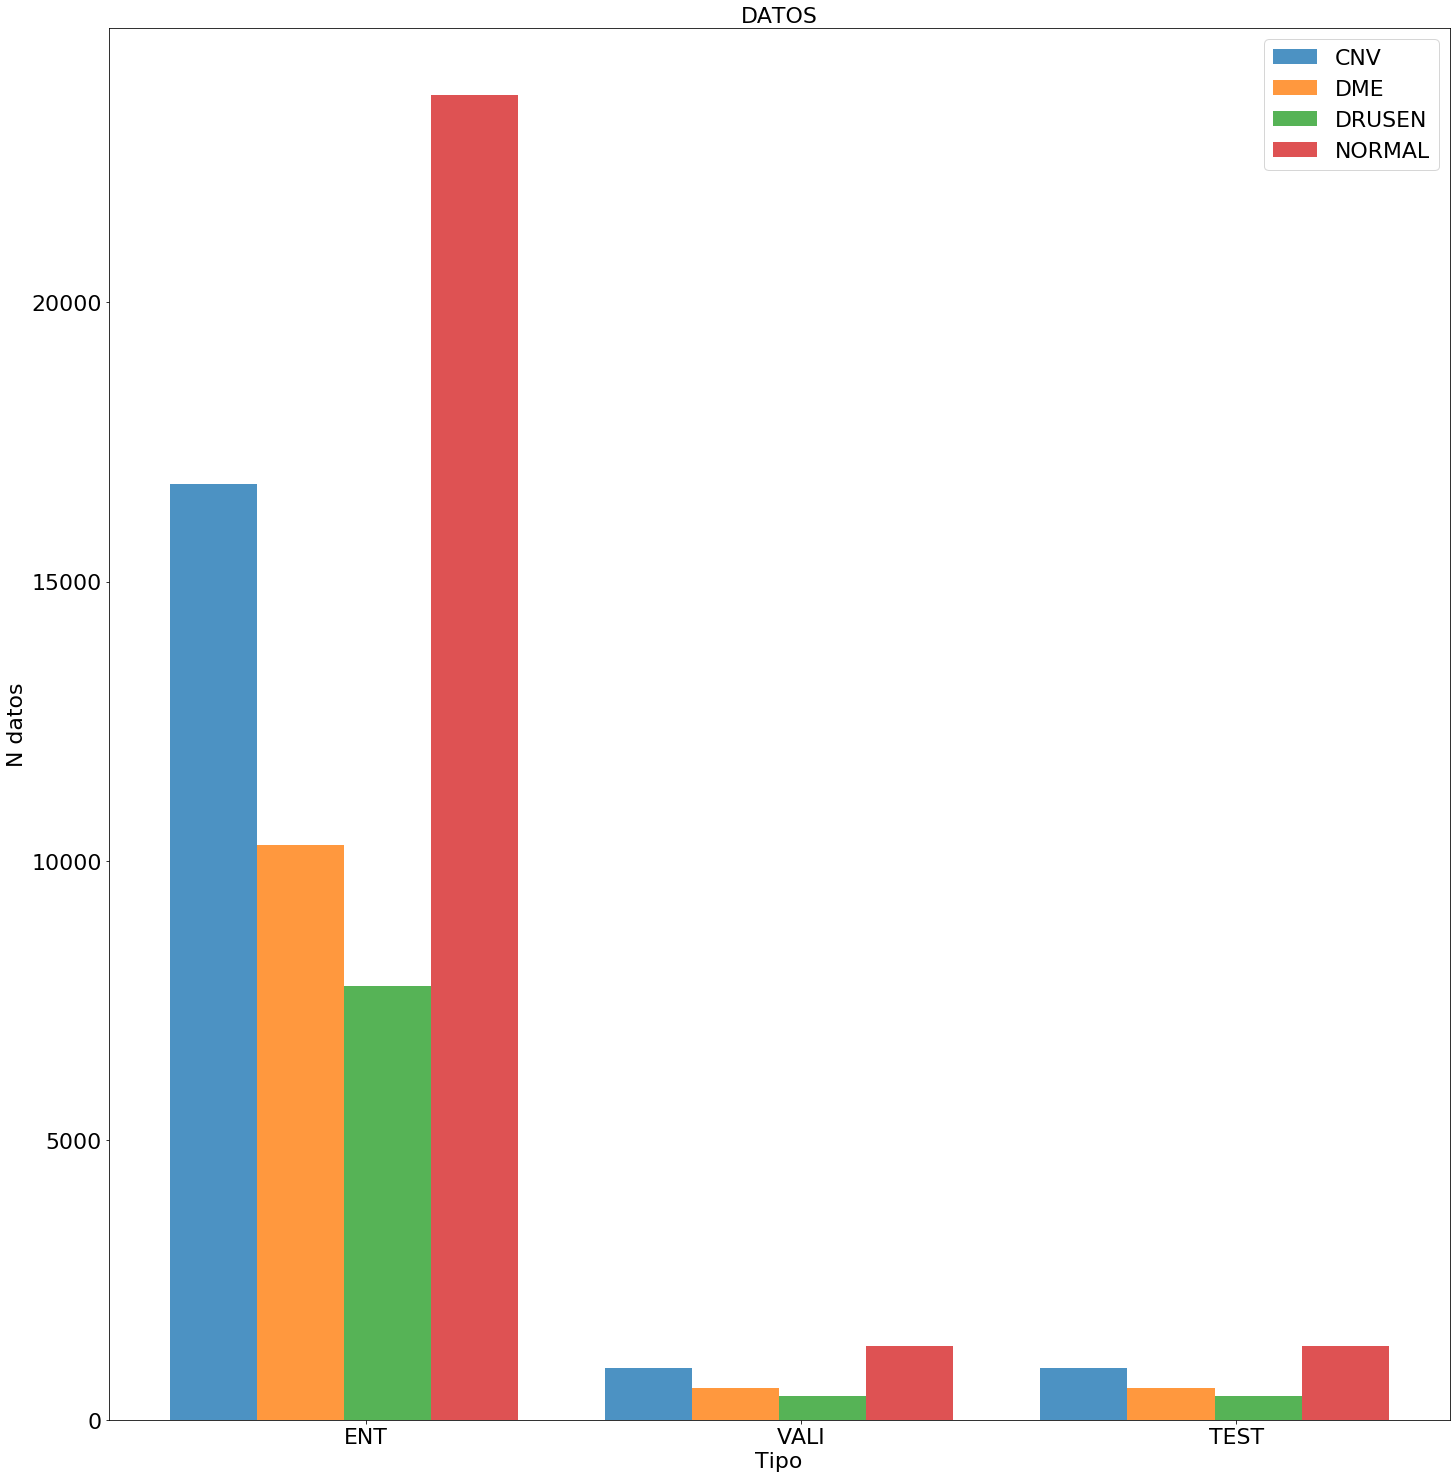

In [10]:
ENTRENAMIENTO,VALIDACION,TEST,STEP_SIZE_TRAIN,STEP_SIZE_VALID,  = creacion_DATA()

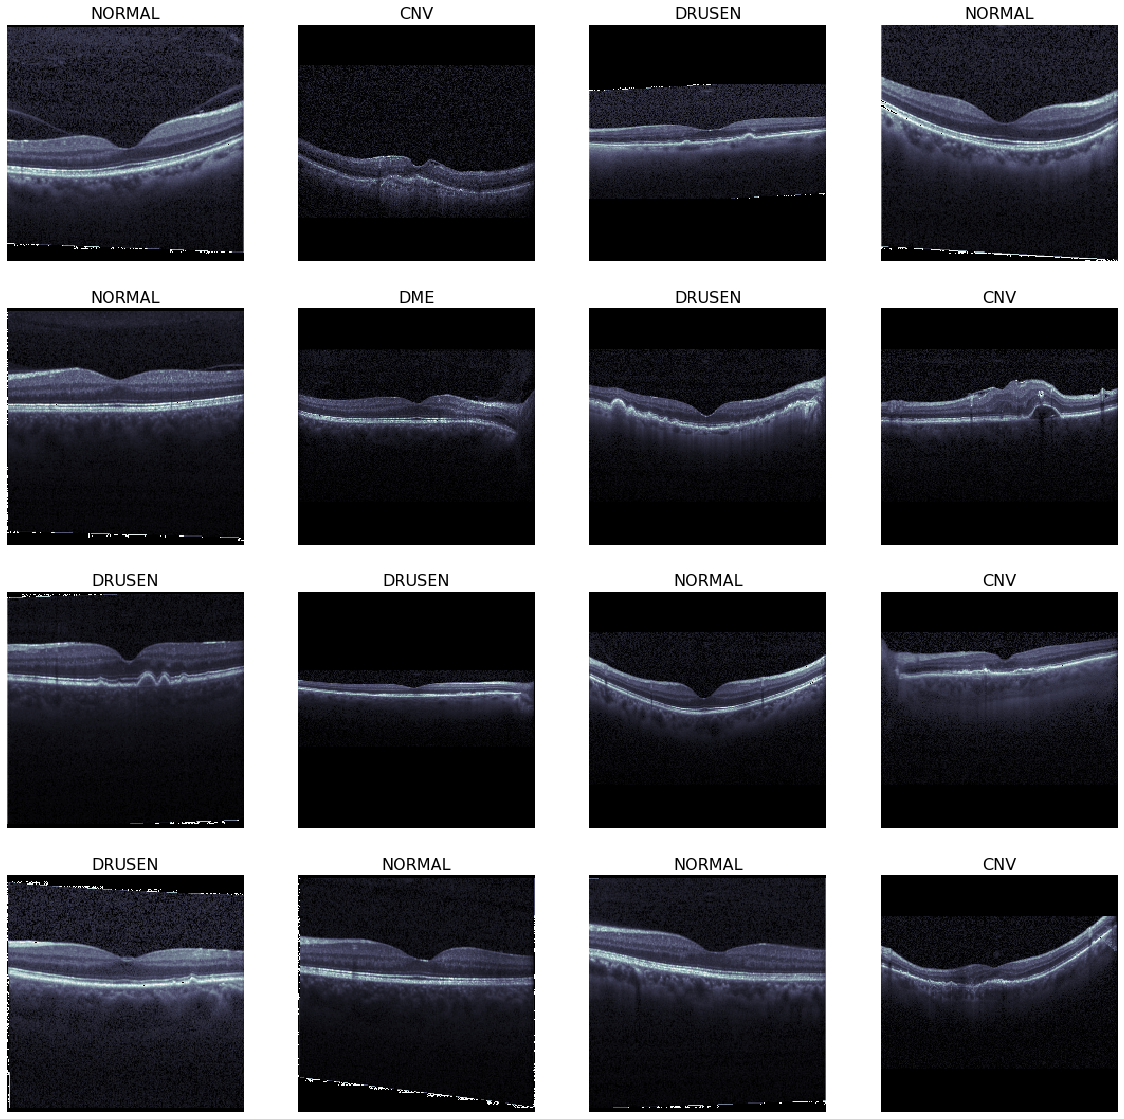

In [11]:
muestra,LAB = next(VALIDACION)
muestra_train(ENTRENAMIENTO)

<h1> Volcado del modelo </h1>
Cargaremos el modelo preentrenado y el archivo log necesario para mostrar las grafica de 'Accuracy y Loss'.

In [12]:
model = load_model(dir_modeloVGG16)
history = np.load(dir_logVGG16,allow_pickle=True)

<h1> Curva de aprendizaje </h1>
El objetico de mostrar estas dos graficas es la de poder analizar la evolucion del entrenamiento por epoca, pudiendo comparar las diferentes evoluciones que toma dependiendo si usamos como medida los datos de entrenamiento o de validacion, pudiendo detectar sobreajustes o directamente descartar un modelo.

La primera grafica representa el nivel de 'acierto' que va teniendo el modelo, este valor va desde [0,1] siendo un numero entorno al 0.5 un resultado nefasto y entorno al 1 un buen resultado simpre y cuadno la curva de validacion acompañe a la de entrenamiento.

La segunda, representa el error o 'perdida' que se comete en cada epoca, indica cuantas imagenes se estan etiquetando de forma erronea.

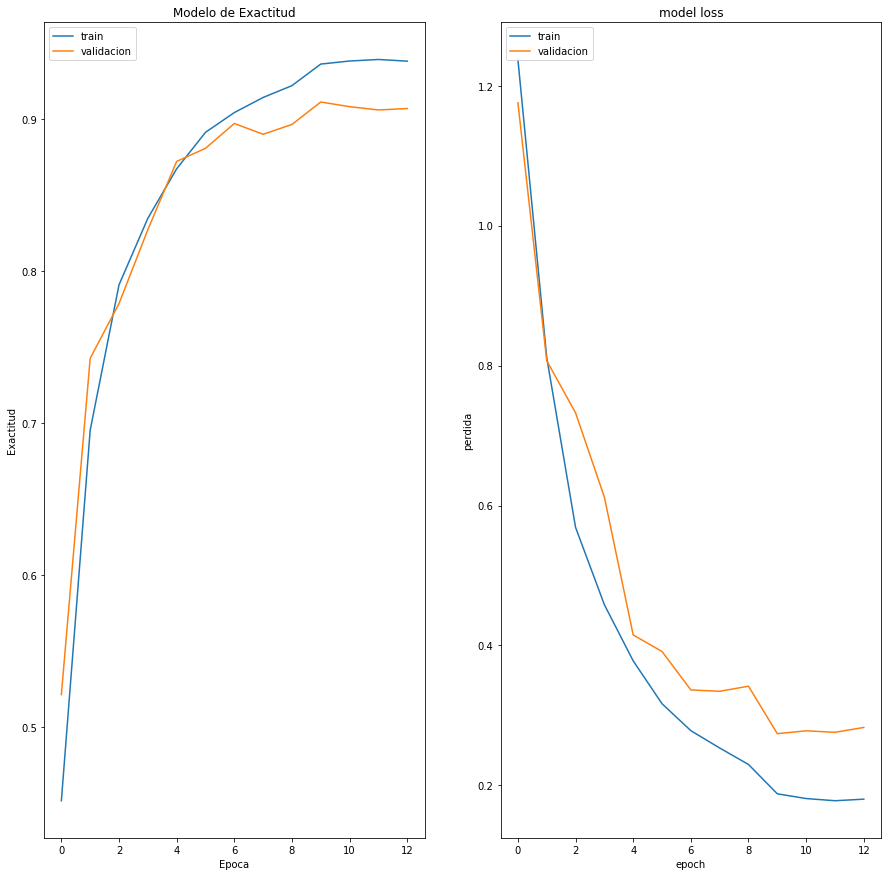

In [13]:
plt_Curva_Aprendizaje(history,nameModel)

<h1> Generar Prediccion </h1>
Una vez cargado el modelo, generamos un vector solucion, para ello usamo la funcion predict_generator, esta funcion se alimenta con la variable TEST que consiste en una estructura de datos dividido en lotes que se constituye por pares de valores (Imagen,label) tambien le proporcionamos el tamaño de esta misma variable. 
El parametros workers se usa para determinar el numero de hilos del procesadores y el verbose si se desea informar  por pantalla el progreso de la funcion en cuestion.

In [20]:
# Prediccion
y_pred = model.predict_generator(TEST, steps=len(TEST), workers = 8, verbose=1)
y_pred_clases = np.argmax(y_pred, axis=1)

204/204 [==============================] - 30s 148ms/step


<h1> Matriz de Confusion </h1>

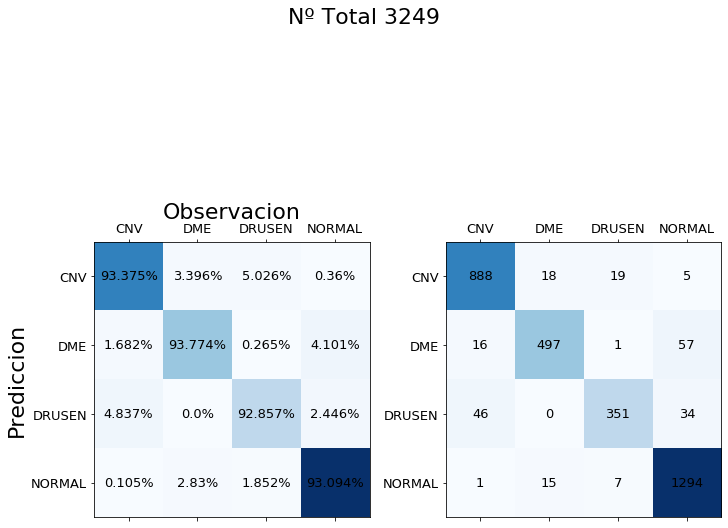

In [21]:
confucion_matrix =  confusion_matrix(TEST.classes, y_pred_clases)
Dibujo_Matrix_Confucion(confucion_matrix, clases=list(Clases), name=nameModel )

<h2> Factor F1 o valor-f  </h2>
El valor-F es una medida de la precisión de una prueba. Considerando tanto la precision  como la recuperacion de la prueba para calcular la puntuacion.
<ul>
    <li> El valor de precision es el ratio entre los verdaderos positivos y todos los valores positivos. Cuanto mas alto sea este indice mas probable que el positivo sea cierto.
    </li>
    <li> El valor de recuperacion es el ratio entre los verdaderos positivos y todos los valores negativos. Cuanto mas alto sea este indice indica que datos que da como positivo no lo son realmente. 
    </li>
</ul>
    <img src = "../Imagen/Recall_Pre.png"> <small> Origen wikipedia </small> <img>

<h2> Curva roc </h2>
Es un estimador de la bondad de la prueba, esta curva se genera comparando la sensibilidad y la especificidad del dataSet.

<ul>
    <li> <b> Sensibilidad </b> Nos indica la capacidad de nuestro estimador para dar con casos posistivos. </li>
    <li> <b> Especificidad </b> Nos indica la capacidad de nuestro estimador para dar como casos negativos los casos realmente negativos. </li>
</ul>

Con estos dos datos podemos generar una funcion tal y  como se muestra en la imagen siguiente.
<img src='../Imagen/Curvas_Roc.png'> De UPO649 1112 prodgom - Trabajo propio, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=17086504 </img> <br>

Esta área posee un valor comprendido entre 0,5 y 1, donde 1 representa un valor diagnóstico perfecto y 0,5 es una prueba sin capacidad discriminatoria diagnóstica.



In [22]:
print("Factor F1 es : {} ".format(f1_score(TEST.classes,y_pred_clases,average = 'micro')))
print("Area de la curva roc : {} ".format(roc_auc_score(TEST.classes,y_pred,average = 'macro',multi_class = 'ovr')))

Factor F1 es : 0.9325946445060018 
Area de la curva roc : 0.9914364654972364 


<h1> Demostracion del Clasificador </h1>
Mostraremos un lote completo de 16 imagenes todas ellas etiquetadas con la clase que determine el clasificador  junto a una grafica de barras que contiene los porcentages de probabilidades de pertenecer a cada clase. Las etiquetas o barras rojas muestra un error en la clasificacion.

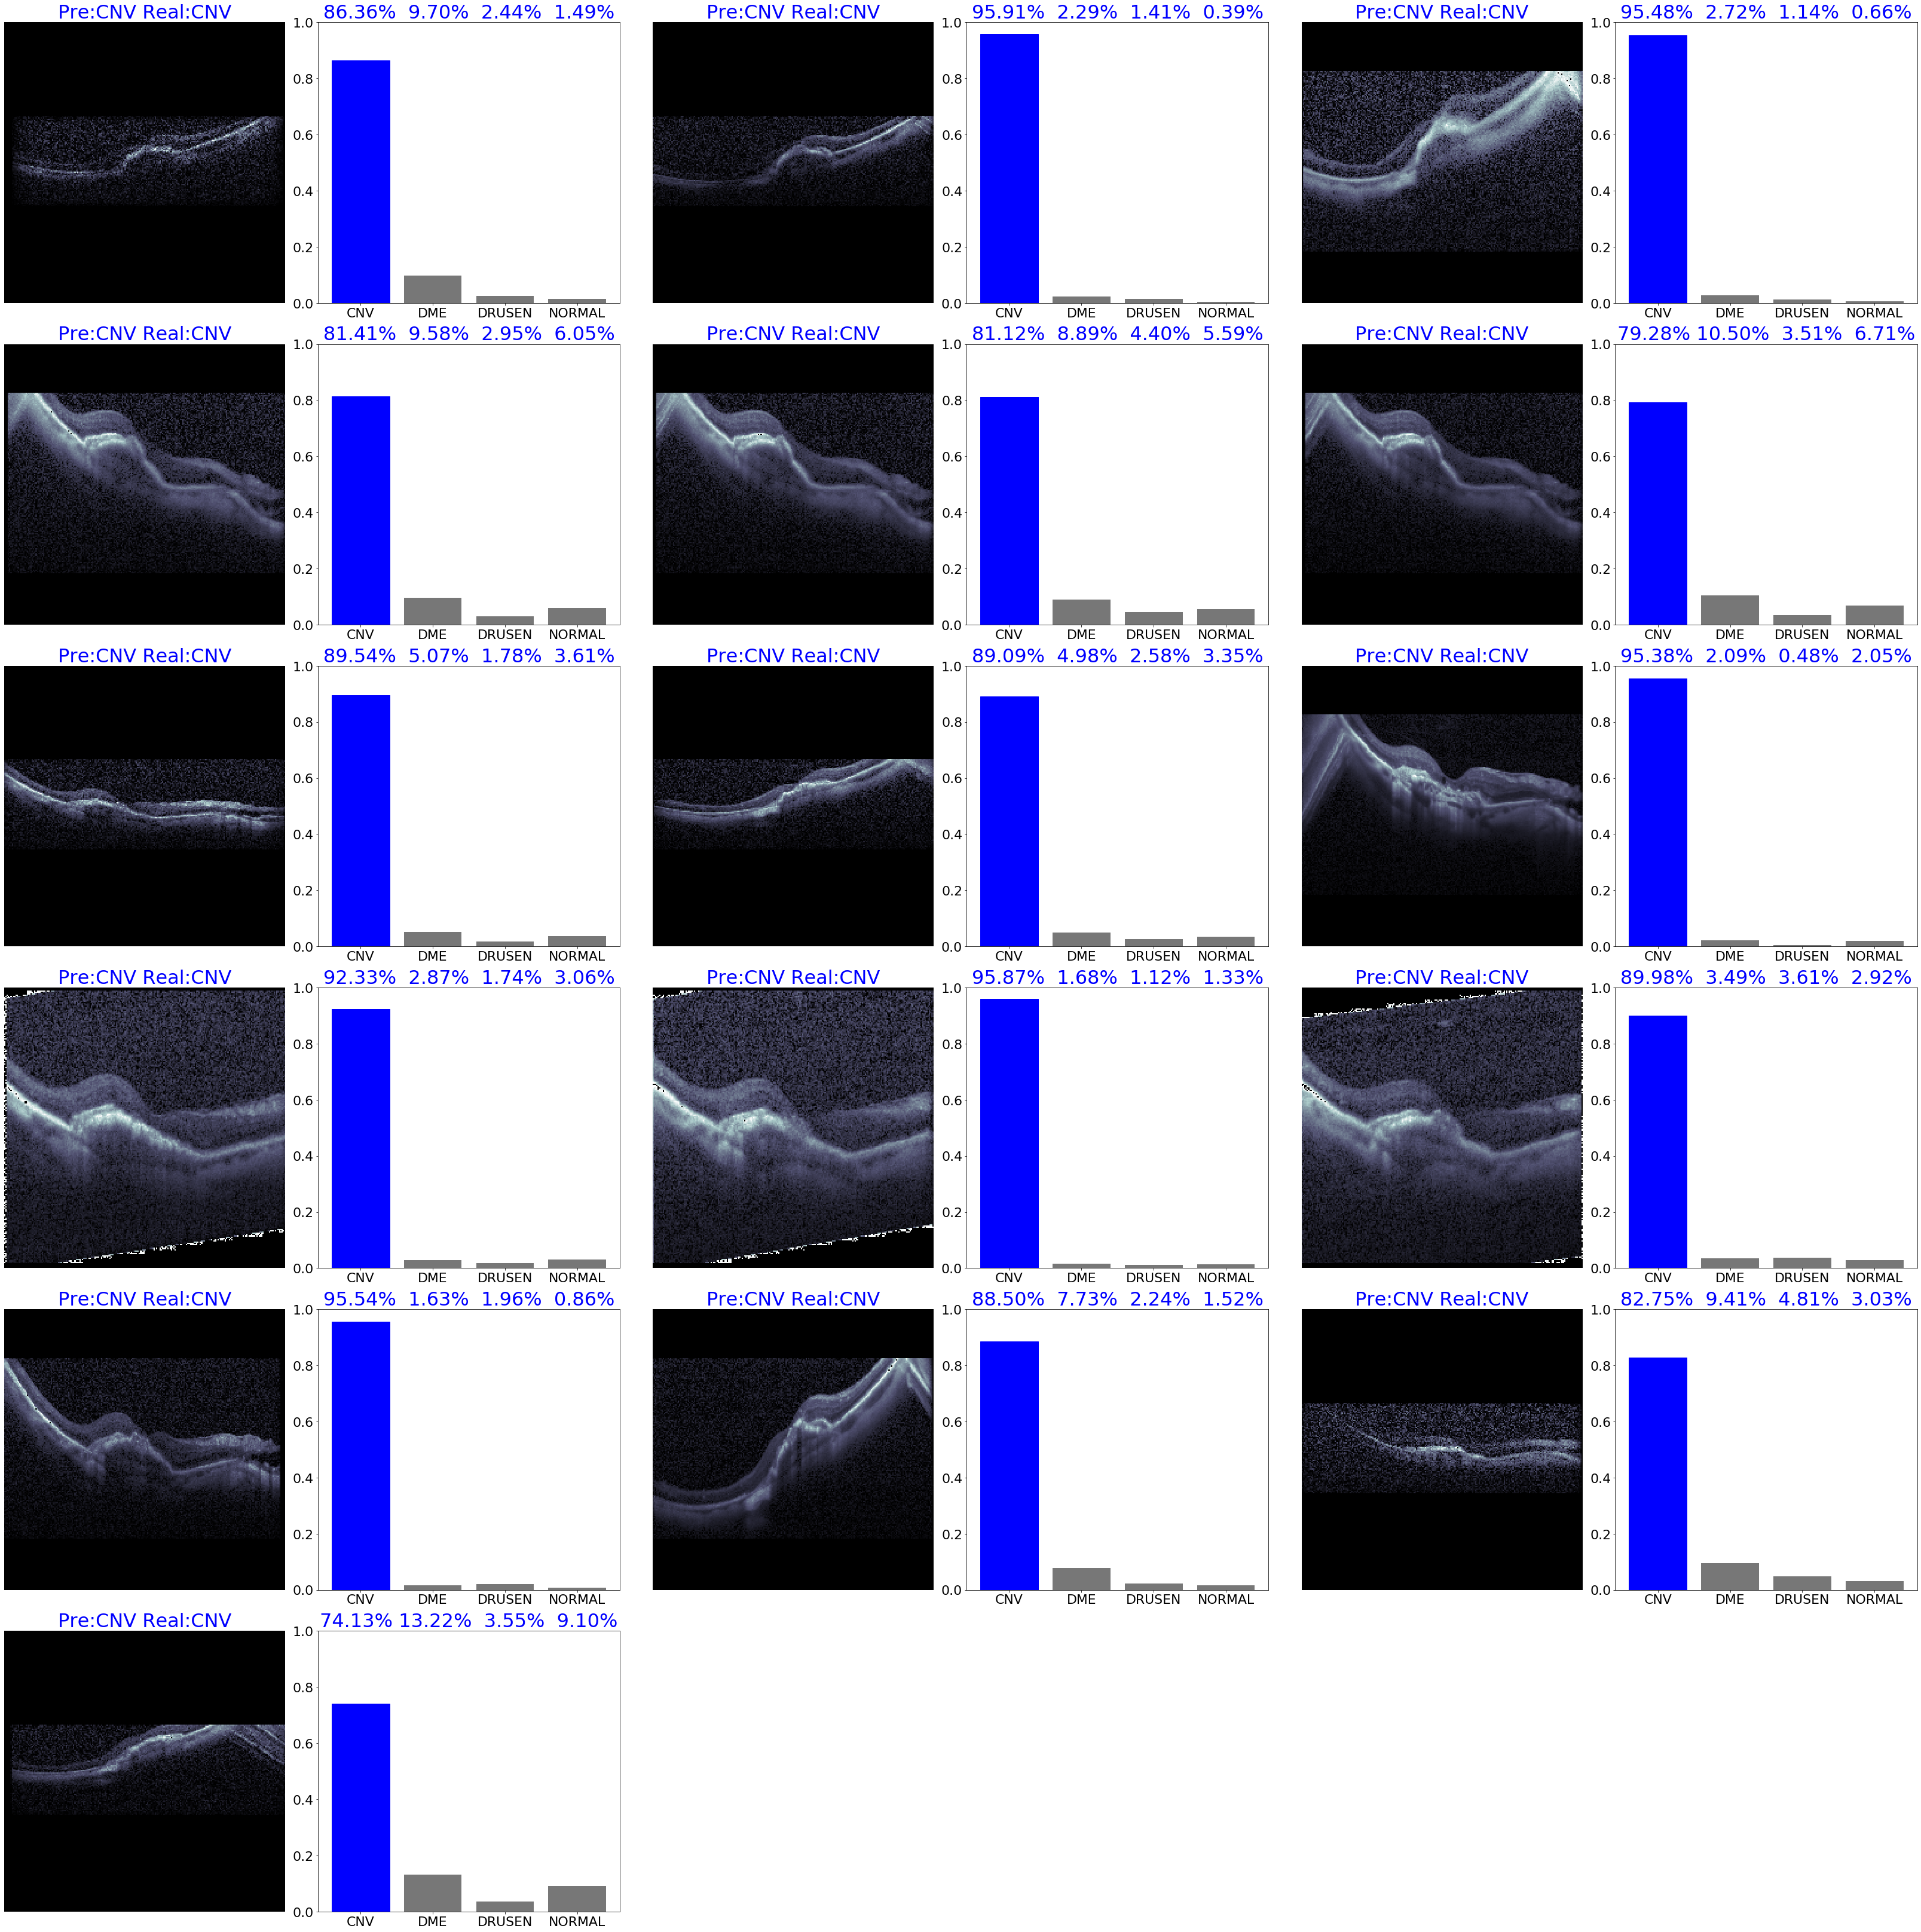

In [23]:
t_x , t_y = next(TEST)
figura = plt.figure(figsize=(45, 45))
i = 1
for (sub_x, sub_y) in zip(t_x, t_y):
    
    a = figura.add_subplot(6, 6, i)
    plt.imshow(sub_x[:,:,0], cmap = 'bone')
    
    tr = sub_x.reshape([-1,Size_Fotos, Size_Fotos,3])
    
    predicted_class = model.predict(tr)
    pr_class = np.argmax(predicted_class[0], axis = 0)
    
    if Clases[pr_class] == Clases[np.argmax(sub_y)]:
        color = 'b'
    else: 
        color = 'r'

    a.set_title("Pre:{} Real:{}".format(Clases[pr_class],Clases[np.argmax(sub_y)]),color = color, fontdict = {'size':32})
    a.axis('off')
    
   
    i = i + 1
    a = figura.add_subplot(6, 6, i)
    plt.ylim([0, 1])
    thisplot = plt.bar(range(4),predicted_class[0], color="#777777")
    
    thisplot[pr_class].set_color('red')
    thisplot[np.argmax(sub_y)].set_color('blue')
    
    index = np.arange(4)
    
    plt.xticks(index, Clases, size=22)
    plt.yticks(size=22)
    plt.tight_layout()
    plt.title("{:5.2f}% {:5.2f}% {:5.2f}% {:5.2f}%".format(round(predicted_class[0][0],4) * 100 ,round(predicted_class[0][1],4) * 100,round(predicted_class[0][2],4) * 100 ,round(predicted_class[0][3],4) * 100),color = color, fontdict = {'size':32})
    i = i + 1
   
    